In [56]:
from google.colab import drive
drive.mount("/content/drive")

import os

from IPython.display import clear_output
path = "/content/drive/MyDrive"
os.chdir(path)

if not os.path.exists("./DIP_Project"):
  os.mkdir(os.path.join(path, "DIP_Project"))
os.chdir("./DIP_Project")


!pip install --upgrade --no-cache-dir gdown # for access is denied problem use this command instead of usual one
# ! pip install gdown
! pip install tqdm
! pip install torch_dct
clear_output()
! pwd

/content/drive/MyDrive/DIP_Project


In [57]:
if not os.path.exists("freq-net"):
  !git clone https://github.com/hamedsa-78/freq-net.git

print()
os.chdir("freq-net")
print()
!ls



config.json  line_plot.png    __pycache__	saved_history  train.py
datasets     model_best.pth   README.MD		setup.py       ts2.ipynb
freq_net     parse_config.py  requirements.txt	test.py


In [ ]:
import gdown

if not os.path.exists("model_best.pth"):
    url = "https://drive.google.com/file/d/1USKVqB1V7fqBpLbF65pvH6r7Tg4JldRh/view?usp=sharing"
    output_path = "model_best.pth"
    gdown.download(url, output_path, quiet=False, fuzzy=True)

clear_output()

# validating

In [ ]:
! python test.py --config config.json --resume model_best.pth

INFO:test:Loading checkpoint: model_best.pth ...
100% 13/13 [13:47<00:00, 63.69s/it]
INFO:test:{'loss': 0.02200232948362827, 'loss_bicubic': 0.026023655012249947, 'psnr': 46.8832275390625, 'bicubic_psnr': 46.4208984375, 'frm': 16.633914794921875, 'bicubic_frm': 15.880689697265625}


# inferencing

  0%|          | 0/13 [01:03<?, ?it/s]

torch.Size([3, 512, 512])


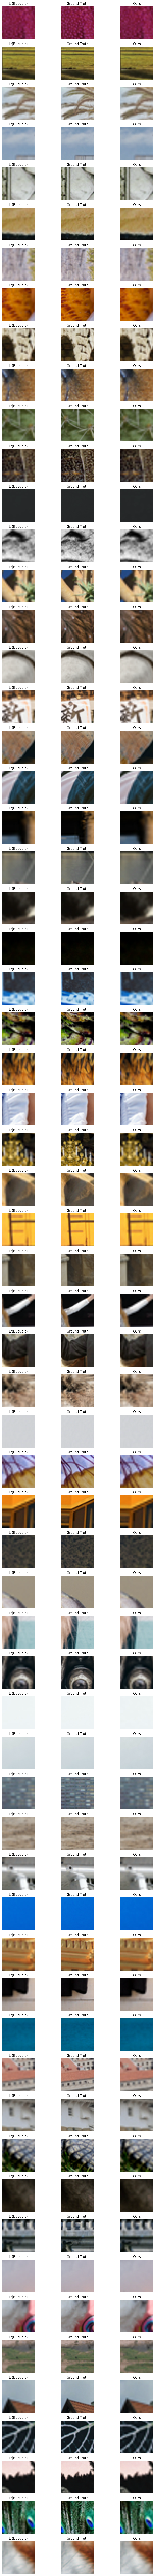

In [196]:
import torch
from tqdm import tqdm

import freq_net.data_loader.data_loaders as module_data

import freq_net.model.model as module_arch

from freq_net.model.model import DirectScaling

import matplotlib.pyplot as plt

import torch
import torchvision.transforms.functional as F


data_loader = module_data.DIV2KDataLoader(
    64,
    "datasets/",
    shuffle=False,
    validation_split=0.0,
    train=True,
    num_workers=0,
)
# build model architecture
model = module_arch.FreqNet(True, 4, 3, 5)
# config.resume : *.pth
checkpoint = torch.load("model_best.pth")
state_dict = checkpoint["state_dict"]


model.load_state_dict(state_dict)
test_model = DirectScaling()
# prepare model for testing
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()
test_model = test_model.to(device)
test_model.eval()
inference_images = []

with torch.no_grad():
    for i, (data, target) in enumerate(tqdm(data_loader)):
        lr_rgb, lr_img, lr_dct = data
        hr_rgb, hr_img, hr_dct = target
        assert lr_img.max() <= 1, "no x is grater than 1"
        assert hr_img.max() <= 1, "no y is grater than 1"
        lr_img, lr_dct, hr_rgb, hr_img, hr_dct = (
            lr_img.to(device),
            lr_dct.to(device),
            hr_rgb.to(device),
            hr_img.to(device),
            hr_dct.to(device),
        )
        _, hr_predicted_img = model(lr_img, lr_dct)  # (B , 3 , 512 , 512)
        _, hr_predicted_direct = test_model(lr_img, lr_dct)  # (B , 3 , 512 , 512)
        for k in range(len(lr_img)):
            inference_images.append(
                (lr_img[k].cpu(), hr_img[k].cpu(), hr_predicted_img[k].cpu())
            )
        break

label_names = ["Lr(Bucubic)", "Ground Truth", "Ours"]
fig, axes = plt.subplots(64, 3, figsize=(10, 128))
axes = axes.flatten()

for i, image_group in enumerate(inference_images):
    for j, image in enumerate(image_group):
        rgb_img = F.to_pil_image(image, mode="YCbCr").convert("RGB")
        rgb_tensor = F.to_tensor(rgb_img)

        axes[i * 3 + j].imshow(
            rgb_tensor.reshape(3, 16, 32, 16, 32)
            .transpose(2, 3)[:, 8, 8, :, :]
            .movedim(0, 2)
        )
        axes[i * 3 + j].axis("off")
        axes[i * 3 + j].set_title(label_names[j])

plt.tight_layout()
plt.show()